Author: Lim Yu Cheng  

100 runs of data are taken. The average is then found.

# References

https://electronics.stackexchange.com/questions/23182/what-does-it-mean-when-multimeter-accuracy-is-marked-as-%C2%B10-0310digit

It's usually because your bins are so far apart that the algo doesn't fit them in relation. Recheck your math (I didn't read through it) to see if that is the case and/or check for any warning/errors generated by your terminal/notebook when you run the fitting.  
https://www.reddit.com/r/learnpython/comments/uaezyi/why_am_i_generating_a_flat_curve_in_my_curve_fit/

# Import

In [1]:
version = '2'

#how many runs
runs = 100

# tbs simple plot
# python v3.x, pyvisa v1.8
# should work with TDS2k, TPS2k, and TBS1k series

# replaced 'wfmoutpre' with 'wfmpre' (see mdo simple plot)

import time # std module
import pyvisa as visa 
import matplotlib.pyplot as plt
import numpy as np 
from scipy import signal, stats, optimize, interpolate
from numpy.typing import NDArray
import ipywidgets as widgets
import pandas as pd

# Task 1

In [104]:
task1 = pd.read_excel("task1_capacitor_data.xlsx")
#小心 does not print all rows!!!


In [105]:
task1.head()

,rise_time1,rise_voltage1,fall_time1,fall_voltage1,rise_time2,rise_voltage2,fall_time2,fall_voltage2,rise_time3,rise_voltage3,fall_time3,fall_voltage3,rise_time4,rise_voltage4,fall_time4,fall_voltage4,rise_time5,rise_voltage5,fall_time5,fall_voltage5
0,19.70,0.329,0.00,4.590,10.0,0.010,5.0,4.820,5.0,0.008,10.0,4.525,10,0.013,5,4.551,3,0.100,5,4.532
1,25.11,0.972,5.10,4.569,15.0,0.569,10.0,4.196,10.0,0.560,15.0,3.953,15,0.616,10,3.954,8,0.733,10,3.937
2,30.43,1.500,10.28,4.052,20.0,1.135,15.0,3.648,15.0,1.126,20.0,3.420,20,1.176,15,3.440,13,1.276,15,3.445
3,35.61,1.954,15.65,3.503,25.0,1.624,20.0,3.175,20.0,1.597,25.0,2.977,25,1.658,20,2.995,18,1.745,20,2.999
4,40.38,2.316,20.28,3.065,30.0,2.046,25.0,2.765,25.0,2.038,30.0,2.593,30,2.075,25,2.609,23,2.150,25,2.613


In [28]:
task1.columns

Index(['rise_time1', 'rise_voltage1', 'fall_time1', 'fall_voltage1',
       'rise_time2', 'rise_voltage2', 'fall_time2', 'fall_voltage2',
       'rise_time3', 'rise_voltage3', 'fall_time3', 'fall_voltage3',
       'rise_time4', 'rise_voltage4', 'fall_time4', 'fall_voltage4',
       'rise_time5', 'rise_voltage5', 'fall_time5', 'fall_voltage5'],
      dtype='object')

for 1mV resolution, error is ±(0.5％＋3 digits）  
the rise curve is funny: without the scaling factor of 10 for time, the fitting fails!

In [118]:
def rise_curve(t, τ, V_0,t_0):
    return V_0*(1-np.exp(-(t-t_0)*0.1/τ))# linear relation
    
def fall_curve(t, τ, V_0):
    return V_0*np.exp(-t/τ) # linear relation

def make_curve(curve, time_raw, voltage_raw):
    time = time_raw[~np.isnan(time_raw)]
    voltage = voltage_raw[~np.isnan(voltage_raw)]
    
    V_err1 = voltage*0.005 + 0.003
    T_err1 = np.full(time.shape, 0.1)
    
    coeff, cov = optimize.curve_fit(curve, time, voltage)
    
    #condition number of covariance matrix
    
    plt.plot(time, curve(time, *coeff))
    plt.errorbar(time, voltage, xerr=T_err1, yerr=V_err1, fmt='o', ms=3)

    return coeff[0]




list of time constants:  [37.10033183 37.24635401 37.0387504  37.18083768 36.97649838]
average time constant =  37.11
error(half of max-min) =  0.13
theoretical time constant = 35.4


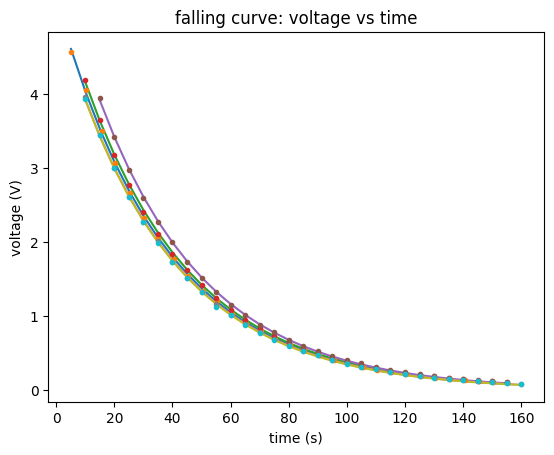

In [94]:
time_const = []

plt.title('falling curve: voltage vs time')
plt.xlabel('time (s)')
plt.ylabel('voltage (V)')


for i in range(0,5):
    τ = make_curve(fall_curve, \
                    task1[f'fall_time{i+1}'].to_numpy()[1:],\
                    task1[f'fall_voltage{i+1}'].to_numpy()[1:]
                    )
    time_const.append(τ)

time_const = np.array(time_const)
av_time_const = np.average(time_const)
err_time_const = (np.max(time_const) - np.min(time_const))/2
theoretical_time_const = 300E3 * 118E-6

print('list of time constants: ', time_const)
print(f'average time constant = {av_time_const: 1.2f}')
print(f'error(half of max-min) = {err_time_const: 1.2f}')
print(f'theoretical time constant = {theoretical_time_const}')

list of time constants:  [36.76717057 35.12851086 36.4278444  36.49935116 36.68113543]
average time constant =  36.30
error(half of max-min) =  0.82
theoretical time constant = 35.4


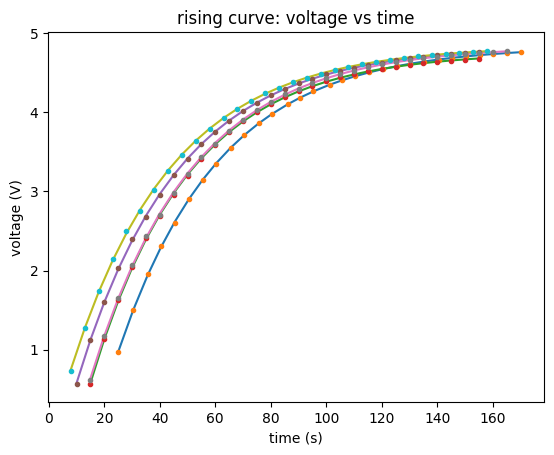

In [119]:
time_const = []

plt.title('rising curve: voltage vs time')
plt.xlabel('time (s)')
plt.ylabel('voltage (V)')


for i in range(0,5):
    τ = make_curve(rise_curve, \
                    task1[f'rise_time{i+1}'].to_numpy()[1:],\
                    task1[f'rise_voltage{i+1}'].to_numpy()[1:]
                    )
    time_const.append(τ)

time_const = np.array(time_const)/0.1
av_time_const = np.average(time_const)
err_time_const = (np.max(time_const) - np.min(time_const))/2
theoretical_time_const = 300E3 * 118E-6

print('list of time constants: ', time_const)
print(f'average time constant = {av_time_const: 1.2f}')
print(f'error(half of max-min) = {err_time_const: 1.2f}')
print(f'theoretical time constant = {theoretical_time_const}')

# Task 2

In [80]:
scaled_time = np.loadtxt('time_'+version+'.txt', dtype=np.float64)
output_wave = np.loadtxt('output_'+version+'.txt', dtype=np.float64)
input_wave = np.loadtxt('input_'+version+'.txt', dtype=np.float64)

We use the max values to determine the 10%, 90% values

In [81]:
in_max = np.max(input_wave[0])
out_max = np.max(output_wave[0])


We must partition the waves into piecewise monotonic segments for the Numpy functions to work. Partitioning is manual...

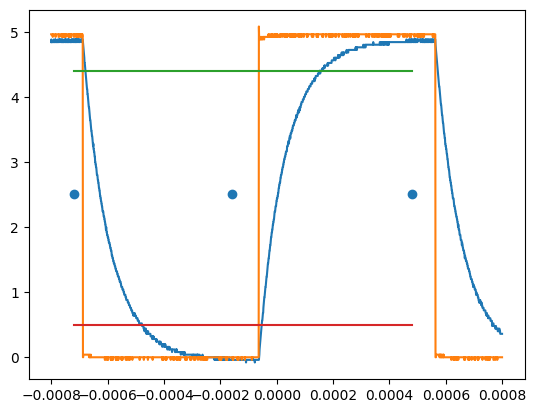

In [82]:
plt.plot(scaled_time, output_wave[0])
plt.plot(scaled_time, input_wave[0])

plt.scatter(scaled_time[[100,800,1600]],[2.5,2.5,2.5])
plt.plot(scaled_time[[100,1600]],[out_max*0.9,out_max*0.9])
plt.plot(scaled_time[[100,1600]],[out_max*0.1,out_max*0.1])


We start solving for the values

In [83]:
def find_percent_value(level, index, time, wave):
    array = []
    for i in range(0, len(index)-1):
        start = index[i]
        stop = index[i+1]
        y = wave[start:stop]
        x = time[start:stop]
        
        #time_10pp.append(np.interp(0.1*5, (-1)**i*unfiltered_wave[0, start:stop], (-1)**i*scaled_time[start:stop]))
        if i%2==1:
            array.append(np.interp(level, y, x))
        else:
            array.append(np.interp(level, y[::-1],x[::-1]))
    return array

fall_time =  0.00020047999999999995
rise_time =  0.00020688000000000005


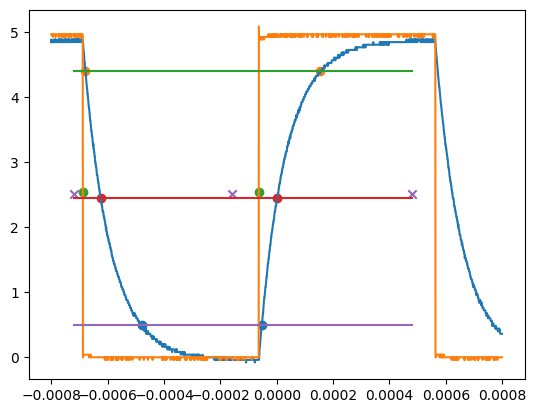

In [84]:
piecewise_index = [100,800,1600]

time_10pp = find_percent_value(0.1*out_max, piecewise_index, scaled_time, output_wave[0])
time_90pp = find_percent_value(0.9*out_max, piecewise_index, scaled_time, output_wave[0])

time_50pp_in = find_percent_value(0.5*out_max, piecewise_index, scaled_time, input_wave[0])
time_50pp_out = find_percent_value(0.5*out_max, piecewise_index, scaled_time, output_wave[0])


plt.scatter(time_10pp, np.full(len(time_10pp), 0.1*out_max))
plt.scatter(time_90pp, np.full(len(time_90pp), 0.9*out_max))

plt.scatter(time_50pp_in, np.full(len(time_50pp_in), 0.5*in_max))
plt.scatter(time_50pp_out, np.full(len(time_50pp_out), 0.5*out_max))


for i in range(0,2):
    if i%2 == 0:
        print("fall_time = ", time_10pp[i] - time_90pp[i])
    else:
        print("rise_time = ", time_90pp[i] - time_10pp[i])




plt.plot(scaled_time, output_wave[0])
plt.plot(scaled_time, input_wave[0])

plt.scatter(scaled_time[[100,800,1600]],[2.5,2.5,2.5], marker = 'x')
plt.plot(scaled_time[[100,1600]],[out_max*0.9,out_max*0.9])
plt.plot(scaled_time[[100,1600]],[out_max*0.5,out_max*0.5])
plt.plot(scaled_time[[100,1600]],[out_max*0.1,out_max*0.1])


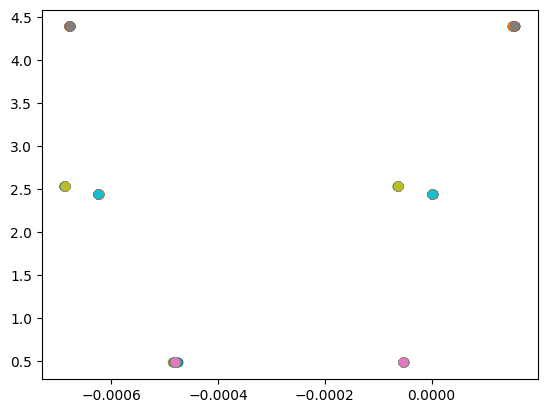

In [85]:
piecewise_index = [100,800,1600]

fall_time = []
rise_time = []
delay_time = []

for j in range(0, output_wave.shape[0]):
    time_10pp = find_percent_value(0.1*out_max, piecewise_index, scaled_time, output_wave[j])
    time_90pp = find_percent_value(0.9*out_max, piecewise_index, scaled_time, output_wave[j])
    
    time_50pp_in = find_percent_value(0.5*out_max, piecewise_index, scaled_time, input_wave[j])
    time_50pp_out = find_percent_value(0.5*out_max, piecewise_index, scaled_time, output_wave[j])
    
    
    plt.scatter(time_10pp, np.full(len(time_10pp), 0.1*out_max))
    plt.scatter(time_90pp, np.full(len(time_90pp), 0.9*out_max))
    
    plt.scatter(time_50pp_in, np.full(len(time_50pp_in), 0.5*in_max))
    plt.scatter(time_50pp_out, np.full(len(time_50pp_out), 0.5*out_max))
    
    
    for i in range(0,2):
        if i%2 == 0:
            fall_time.append(time_10pp[i] - time_90pp[i])
        else:
            rise_time.append(time_90pp[i] - time_10pp[i])

    
    
    delay_time.append(time_50pp_out[0]-time_50pp_in[0])
    delay_time.append(time_50pp_out[1]-time_50pp_in[1])

In [123]:
print('average rise time = ', np.average(np.array(rise_time)))
print('std deviation = ', np.std(np.array(rise_time),dtype=np.float64))

print()
print('average fall time = ', np.average(np.array(fall_time)))
print('std deviation = ', np.std(np.array(fall_time),dtype=np.float64))
print()


print('average delay time = ', np.average(np.array(delay_time)))
print('std deviation = ', np.std(np.array(delay_time),dtype=np.float64))


average rise time =  0.00020666240000000006
std deviation =  1.3157059853933978e-06

average fall time =  0.00019800159999999996
std deviation =  1.61762215612918e-06

average delay time =  6.39309021656302e-05
std deviation =  1.106265033622874e-06


# Task 3
We limit the range of data we take because for voltage smaller than 1 volt, the discretization of the waveform becomes apparent, leading to large error

So we need to find the optimum range, which I've found to be about 410

In [124]:
@widgets.interact(end=(150, 700))
def plot_wave(end=410):
    gradient = []
    error = []
    start = 150
    
    fig, ax = plt.subplots(1,1)
    
    time = scaled_time[start:end]*1000
    log_V = np.log(output_wave[0,start:end])
    
    
    ax.plot(time, log_V)
    
    line = stats.linregress(time, log_V)
    
    line_label = r'fitted line: ({:1.3f} $\pm$ {:1.3f}) t + {:1.0f}'\
    .format(float(line.slope), float(line.stderr), float(line.intercept))
    
    ax.plot(time, line.intercept + line.slope*time, label = line_label)
    
    ax.legend(loc='upper left', frameon=False)
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('voltage (natural log)')
    
    fig.tight_layout()

interactive(children=(IntSlider(value=410, description='end', max=700, min=150), Output()), _dom_classes=('wid…

To estimate the potential error in gradient, we try to choose different lengths of interval. Apparently the greater the interval, the more negrative the gradient and the further the measured time constant is from the theoretical value.

In [114]:
end_array = [300,400,450,500,550,600]

start = 150

for end in end_array:
    
    gradient = []
    error = []
    
    for i in range(0,runs):
        time = scaled_time[start:end]*1000
        log_V = np.log(output_wave[i,start:end])
    
        line = stats.linregress(time, log_V)
        
        line_label = r'fitted line: ({:1.3f} +/- {:1.3f}) t + {:1.0f}'\
        .format(float(line.slope), float(line.stderr), float(line.intercept))
    
        #print(line_label)
    
        gradient.append(line.slope)
        error.append(line.stderr)
    


    av_gradient = np.sum(np.array(gradient))/runs
    av_error = np.sum(np.array(error))/runs
    print('ends at',end,'the average gradient',\
          '{:1.3f}'.format(av_gradient),\
          '+-', '{:1.3f}'.format(av_error))



ends at 300 the average gradient -10.856 +- 0.018
ends at 400 the average gradient -10.965 +- 0.017
ends at 450 the average gradient -11.056 +- 0.019
ends at 500 the average gradient -11.237 +- 0.025
ends at 550 the average gradient -11.512 +- 0.035
ends at 600 the average gradient -11.957 +- 0.057


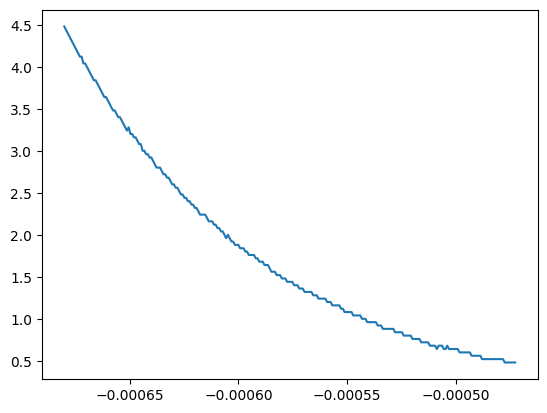

In [111]:
# It is important to check that the part to be extracted is correct

plt.plot(scaled_time[150:410], output_wave[0, 150:410])

A single run

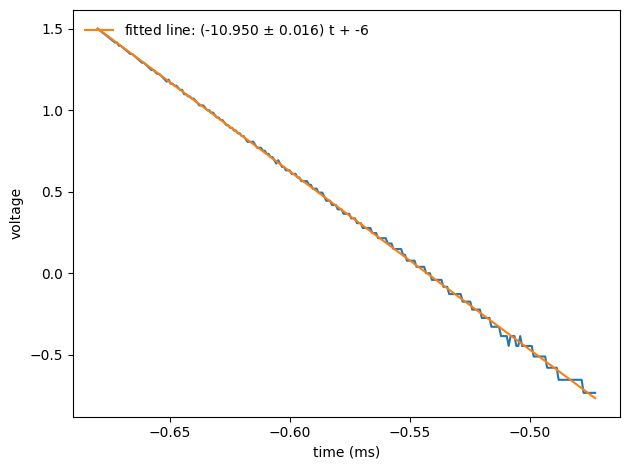

In [112]:

fig, ax = plt.subplots(1,1)

start = 150
end = 410

time = scaled_time[start:end]*1000
log_V = np.log(output_wave[0,start:end])


ax.plot(time, log_V)

line = stats.linregress(time, log_V)

line_label = r'fitted line: ({:1.3f} $\pm$ {:1.3f}) t + {:1.0f}'\
.format(float(line.slope), float(line.stderr), float(line.intercept))

ax.plot(time, line.intercept + line.slope*time, label = line_label)

ax.legend(loc='upper left', frameon=False)
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage')

fig.tight_layout()

For all runs
For the error, we use the standard deviation instead of the error of the fit

the average gradient -10.980 +- 0.017
standard deviation 0.03835953450110751


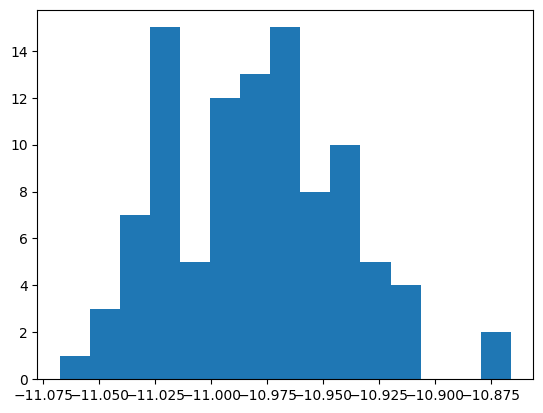

In [115]:
gradient = []
error = []


start = 150
end = 410

for i in range(0,runs):
    time = scaled_time[start:end]*1000
    log_V = np.log(output_wave[i,start:end])

    line = stats.linregress(time, log_V)
    
    line_label = r'fitted line: ({:1.3f} +/- {:1.3f}) t + {:1.0f}'\
    .format(float(line.slope), float(line.stderr), float(line.intercept))

    #print(line_label)

    gradient.append(line.slope)
    error.append(line.stderr)
    
plt.hist(gradient, bins=15)

av_gradient = np.sum(np.array(gradient))/runs
av_error = np.sum(np.array(error))/runs
standard_deviation = np.std(gradient, dtype=np.float64)

print('the average gradient',\
      '{:1.3f}'.format(av_gradient),\
      '+-', '{:1.3f}'.format(av_error))

print('standard deviation', standard_deviation)


# Optional

In [18]:
optional = pd.read_excel("optional_capacitor_data.xlsx")

In [19]:
optional.columns

Index(['freq', 'Vpkpk'], dtype='object')

In [20]:
freq = optional['freq'].to_numpy()
Vpkpk = optional['Vpkpk'].to_numpy()

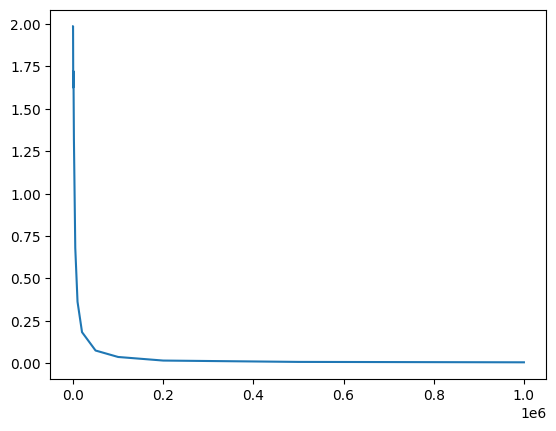

In [21]:
plt.plot(freq,Vpkpk)

In [22]:
log_freq = np.log10(freq)

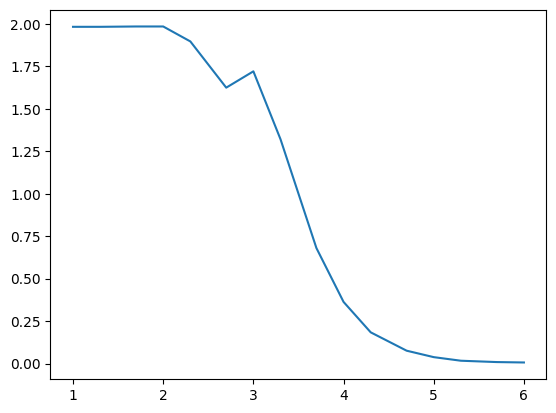

In [23]:
plt.plot(log_freq,Vpkpk)